In [3]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras import regularizers


from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import load_img

from tqdm.notebook import tqdm
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image



from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Age Classification Convolutional Neural Network

## Overview
We will build three neural networks to classify age, gender, and emotions.

### Age Classification
The first neural network will classify age into the following bins:

- <span style="color:blue">Age 1-2</span>
- <span style="color:green">Age 3-9</span>
- <span style="color:orange">Age 10-20</span>
- <span style="color:red">Age 21-27</span>
- <span style="color:">Age 28-45</span>
- <span style="color:purple">Age 46-65</span>
- <span style="color:yellow">Age +66</span>




# Data Import

## Dataset Selection
We will use the augmented open-source dataset called <span style="color:blue">"UTKFace"</span>. This dataset comprises over <span style="color:green">200,000 images</span> of individuals ranging from <span style="color:orange">1 to 100 years</span> of age.


e.


In [4]:
BASE_DIR_train ="/kaggle/input/augmented-age-dataset/augmented_age_dataset/content/combined_faces_train_augmented/"

BASE_DIR_test ="/kaggle/input/augmented-age-dataset/age_dataset/content/combined_faces/"



In [5]:
age_classes=['1-2','3-9','10-20','21-27','28-45','46-65','+66']



In [6]:
image_paths_train = []
age_labels_train = []

for filename in tqdm(os.listdir(BASE_DIR_train)):
    image_path = os.path.join(BASE_DIR_train, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths_train.append(image_path)
    age_labels_train.append(age)


  0%|          | 0/234400 [00:00<?, ?it/s]

In [7]:
image_paths_test = []
age_labels_test = []

for filename in tqdm(os.listdir(BASE_DIR_test)):
    image_path = os.path.join(BASE_DIR_test, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths_test.append(image_path)
    age_labels_test.append(age)


  0%|          | 0/33486 [00:00<?, ?it/s]

In [8]:
df_age_train = pd.DataFrame()
df_age_train['image'], df_age_train['age'] = image_paths_train, age_labels_train
df_age_train.head()

,image,age
0,/kaggle/input/augmented-age-dataset/augmented_...,8
1,/kaggle/input/augmented-age-dataset/augmented_...,17
2,/kaggle/input/augmented-age-dataset/augmented_...,31
3,/kaggle/input/augmented-age-dataset/augmented_...,78
4,/kaggle/input/augmented-age-dataset/augmented_...,90


In [9]:
df_age_test = pd.DataFrame()
df_age_test['image'], df_age_test['age'] = image_paths_test, age_labels_test
df_age_test.head()

,image,age
0,/kaggle/input/augmented-age-dataset/age_datase...,8
1,/kaggle/input/augmented-age-dataset/age_datase...,30
2,/kaggle/input/augmented-age-dataset/age_datase...,20
3,/kaggle/input/augmented-age-dataset/age_datase...,3
4,/kaggle/input/augmented-age-dataset/age_datase...,23


# Age Binning
We will transform the ages into <span style="color:blue">bins</span> for better classification
.

# Gender Classification
We will transform the gender column from <span style="color:red">Binary</span>  into <span style="color:blue">Classes</span> for better classification.

## Data Validation

### Results
The results were successful. We managed to import our data and store it into our variables.
riables.


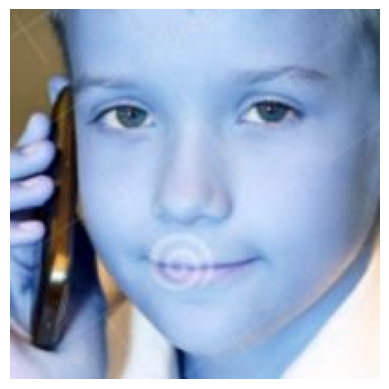

In [10]:
img = Image.open(df_age_train['image'][0])
plt.axis('off')
plt.imshow(img);

In [11]:
df_age_train.shape

(234400, 2)

In [12]:
def age_bins(age):

    if 1 <= age <= 2:
        return '1-2'
    elif 3 <= age <= 9:
        return '3-9'
    elif 10 <= age <= 20:
        return '10-20'
    elif 21 <= age <= 27:
        return '21-27'
    elif 28 <= age <= 45:
        return '28-45'
    elif 46 <= age <= 65:
        return '46-65'
    else:
        return '+66'

In [13]:
def age_bins_encoded(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6


In [14]:
df_age_train['age_bins']=df_age_train['age'].apply(age_bins)
df_age_test['age_bins']=df_age_test['age'].apply(age_bins)

In [15]:
df_age_train['age_enc']=df_age_train['age'].apply(age_bins_encoded)
df_age_test['age_enc']=df_age_test['age'].apply(age_bins_encoded)

In [16]:
df_age_train

,image,age,age_bins,age_enc
0,/kaggle/input/augmented-age-dataset/augmented_...,8,3-9,1
1,/kaggle/input/augmented-age-dataset/augmented_...,17,10-20,2
2,/kaggle/input/augmented-age-dataset/augmented_...,31,28-45,4
3,/kaggle/input/augmented-age-dataset/augmented_...,78,+66,6
4,/kaggle/input/augmented-age-dataset/augmented_...,90,+66,6
...,...,...,...,...
234395,/kaggle/input/augmented-age-dataset/augmented_...,85,+66,6
234396,/kaggle/input/augmented-age-dataset/augmented_...,63,46-65,5
234397,/kaggle/input/augmented-age-dataset/augmented_...,59,46-65,5
234398,/kaggle/input/augmented-age-dataset/augmented_...,1,1-2,0


In [17]:
df_age_test

,image,age,age_bins,age_enc
0,/kaggle/input/augmented-age-dataset/age_datase...,8,3-9,1
1,/kaggle/input/augmented-age-dataset/age_datase...,30,28-45,4
2,/kaggle/input/augmented-age-dataset/age_datase...,20,10-20,2
3,/kaggle/input/augmented-age-dataset/age_datase...,3,3-9,1
4,/kaggle/input/augmented-age-dataset/age_datase...,23,21-27,3
...,...,...,...,...
33481,/kaggle/input/augmented-age-dataset/age_datase...,37,28-45,4
33482,/kaggle/input/augmented-age-dataset/age_datase...,27,21-27,3
33483,/kaggle/input/augmented-age-dataset/age_datase...,35,28-45,4
33484,/kaggle/input/augmented-age-dataset/age_datase...,7,3-9,1


# Data Visualization

### File Information Extraction
To kickstart our data visualization process, we'll import the filenames into a dataframe.Extracting the details encapsulated within the filenames, including <span style="color:blue">name</span>, <span style="color:green">age</span>, and <span style="color:orange">gender</span>.



## Age Distribution

### Training Dataset
- **28-45**: <span style="color:blue">65,490</span> instances
- **21-27**: <span style="color:red">46,840</span> instances
- **46-65**: <span style="color:yellow">39,190</span> instances
- **1-2**: <span style="color:orange">22,340</span> instances
- **10-20**: <span style="color:purple">21,950</span> instances
- **3-9**: <span style="color:green">19,710</span> instances
- **+66**: <span style="color:pink">18,880</span> instances

### Test Dataset
- **28-45**: <span style="color:blue">9,356</span> instances
- **21-27**: <span style="color:red">6,691</span> instances
- **46-65**: <span style="color:yellow">5,598</span> instances
- **1-2**: <span style="color:orange">3,192</span> instances
- **10-20**: <span style="color:purple">3,136</span> instances
- **3-9**: <span style="color:green">2,816</span> instances
- **+66**: <span style="color:pink">2,697</span> instances

### Interpretation
The training dataset exhibits a similar age distribution pattern to the test dataset, with the highest representation in the 28-45 and 21-27 age groups. However, the training dataset contains substantially more instances compared to the test dataset across all age bins, indicating potential differences in data volume and distribution between the two sets.

The skew towards younger age groups, particularly 28-45 and 21-27, in both datasets may impact model performance and generalization. It's essential to consider this distribution during model training and evaluation to ensure robust performance across all age categories.


In [18]:
df_age_train['age_bins'].value_counts()

age_bins
28-45    65490
21-27    46840
46-65    39190
1-2      22340
10-20    21950
3-9      19710
+66      18880
Name: count, dtype: int64

In [19]:
df_age_test['age_bins'].value_counts()

age_bins
28-45    9356
21-27    6691
46-65    5598
1-2      3192
10-20    3136
3-9      2816
+66      2697
Name: count, dtype: int64

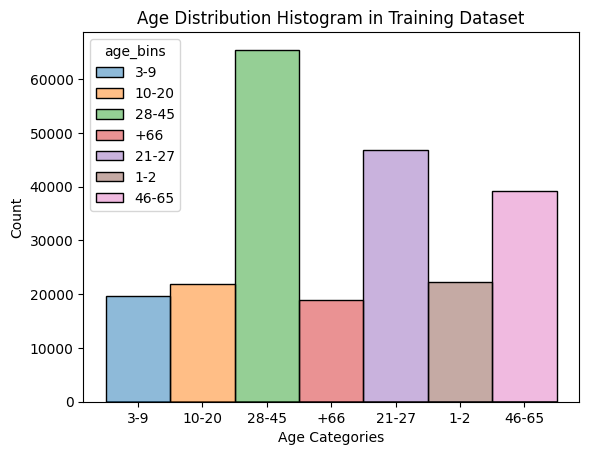

(None,)

In [20]:
import warnings
warnings.filterwarnings("ignore")

sns.histplot(x=df_age_train['age_bins'], hue='age_bins', data=df_age_train)
plt.title('Age Distribution Histogram in Training Dataset')
plt.xlabel('Age Categories')
plt.show(),

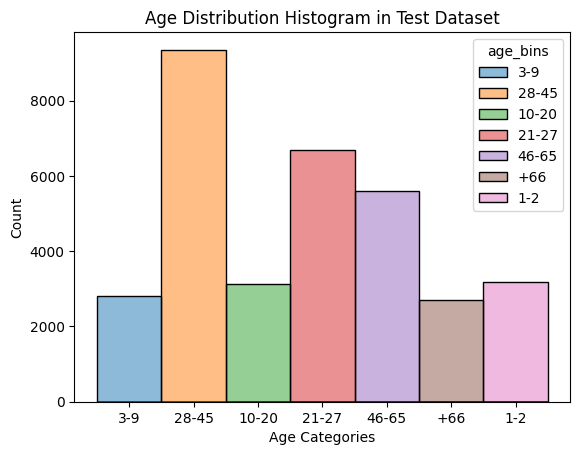

(None,)

In [21]:

sns.histplot(x=df_age_test['age_bins'], hue='age_bins', data=df_age_test, bins=age_classes)
plt.title('Age Distribution Histogram in Test Dataset')
plt.xlabel('Age Categories')

plt.show(),

## Data Preparation and Dataframe Creation

### Loading and Preprocessing
- **train_image_list**: <span style="color:blue">Training</span> image file paths.
- **train_labels_list**: <span style="color:blue">Training</span> age labels.
- **test_image_list**: <span style="color:orange">Test</span> image file paths.
- **test_labels_list**: <span style="color:orange">Test</span> age labels.
- **train_image_list_tf**: <span style="color:blue">Training</span> image file paths (TensorFlow constant).
- **train_labels_list_tf**: <span style="color:blue">Training</span> age labels (TensorFlow constant).
- **test_image_list_tf**: <span style="color:orange">Test</span> image file paths (TensorFlow constant).
- **test_labels_list_tf**: <span style="color:orange">Test</span> age labels (TensorFlow constant).
- **num_classes**: <span style="color:green">Number</span> of age categories (7).

### Parsing Function
- **_parse_function(filename, label)**: Parses images and labels.
    - Reads image files.
    - Decodes JPEG images.
    - Converts labels to one-hot encoded vectors.


In [22]:
train_image_list = list(df_age_train['image'])
train_labels_list = list(df_age_train['age_enc'])

test_image_list = list(df_age_test['image'])
test_labels_list = list(df_age_test['age_enc'])

In [23]:
train_image_list_tf = tf.constant(train_image_list)
train_labels_list_tf = tf.constant(train_labels_list)

test_image_list_tf = tf.constant(test_image_list)
test_labels_list_tf = tf.constant(test_labels_list)

In [24]:
num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [25]:

train_image_dataset = tf.data.Dataset.from_tensor_slices((train_image_list_tf, train_labels_list_tf))
train_image_dataset = train_image_dataset.map(_parse_function)
train_image_dataset = train_image_dataset.batch(312) 


test_image_dataset = tf.data.Dataset.from_tensor_slices((test_image_list_tf, test_labels_list_tf))
test_image_dataset = test_image_dataset.map(_parse_function)
test_image_dataset = test_image_dataset.batch(312) 

In [26]:
train_image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

# Age Classification Model

## Model Architecture

The age classification model incorporates the VGG16 architecture with additional layers for fine-tuning. At the forefront of VGG16, a preprocessing layer has been added to normalize input data. This is followed by frozen convolutional layers from VGG16 for feature extraction, preventing them from being retrained. Subsequently, fully connected layers are introduced for further feature processing and age classification. 

The model architecture involves dense layers with leaky ReLU activation functions to introduce non-linearity, followed by dropout layers for regularization to prevent overfitting. The output layer employs a <span style="color:orange">softmax activation function</span> to predict age categories.

## Compilation
The model is compiled using the <span style="color:blue">Adamax optimizer</span> with a learning rate of <span style="color:green">0.0001</span>. <span style="color:orange">Categorical cross-entropy loss</span> is utilized as the loss function, which is suitable for multi-class classification tasks.

## Model Training
Training is conducted using a batch size of <span style="color:green">64</span> over <span style="color:green">18</span> epochs. <span style="color:orange">Early stopping</span> with a patience of <span style="color:green">5</span> is employed to prevent overfitting, and the best model weights are restored. The training and validation data are evaluated for accuracy metrics.

## Results

The training of the age classification model was carried out over 18 epochs. Here are the key observations from the training process:

- The initial epoch showed an accuracy of <span style="color:orange">26.56%</span> and a loss of <span style="color:orange">1.6319</span>.
- Subsequent epochs demonstrated steady improvement in both accuracy and loss.
- By the final epoch, the model achieved an accuracy of <span style="color:green">72.99%</span> with a loss of <span style="color:green">0.6339</span> on the training data.
- The validation accuracy and loss were <span style="color:green">66.45%</span> and <span style="color:green">0.7639</span>, respectively, indicating reasonable generalization performance.

Overall, the training process showed consistent improvement in model performance, with the final model achieving satisfactory accuracy and loss metrics on both training and validation datasets.



In [24]:



model = tf.keras.models.Sequential()


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())


model.add(layers.Dense(7, activation='softmax'))  


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:


early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)


#Callbacks
callbacks_list=[early_stopping_callback]

model.compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])


                

In [ ]:

history=model.fit(
    train_image_dataset,
    batch_size=312,    
    epochs=30,
    callbacks=callbacks_list,
    validation_data=test_image_dataset,
    verbose=2,
    shuffle=False


)


Epoch 1/18


I0000 00:00:1711992358.613849      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711992358.634150      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


752/752 - 646s - 859ms/step - accuracy: 0.4490 - loss: 1.3608 - val_accuracy: 0.2019 - val_loss: 2.3184
Epoch 2/18
752/752 - 482s - 641ms/step - accuracy: 0.5427 - loss: 1.0933 - val_accuracy: 0.2415 - val_loss: 2.3568
Epoch 3/18
752/752 - 482s - 640ms/step - accuracy: 0.5802 - loss: 0.9997 - val_accuracy: 0.3775 - val_loss: 1.5434
Epoch 4/18
752/752 - 502s - 667ms/step - accuracy: 0.6026 - loss: 0.9444 - val_accuracy: 0.3162 - val_loss: 1.7583
Epoch 5/18
752/752 - 481s - 639ms/step - accuracy: 0.6192 - loss: 0.9034 - val_accuracy: 0.4653 - val_loss: 1.2603
Epoch 6/18
752/752 - 481s - 639ms/step - accuracy: 0.6348 - loss: 0.8659 - val_accuracy: 0.5602 - val_loss: 1.0392
Epoch 7/18
752/752 - 481s - 639ms/step - accuracy: 0.6488 - loss: 0.8336 - val_accuracy: 0.4984 - val_loss: 1.2277
Epoch 8/18
752/752 - 480s - 639ms/step - accuracy: 0.6621 - loss: 0.8032 - val_accuracy: 0.4878 - val_loss: 1.2674
Epoch 9/18
752/752 - 480s - 639ms/step - accuracy: 0.6739 - loss: 0.7749 - val_accuracy: 0.

# Results Visualization

In [27]:
from keras.models import load_model
model= load_model('/kaggle/input/facial-age-relu-final-0-2/age_model_aug.h5')

In [28]:
y_predict = model.predict(test_image_dataset)


108/108 ━━━━━━━━━━━━━━━━━━━━ 984s 9s/step


In [37]:
model.evaluate(test_image_dataset)

108/108 ━━━━━━━━━━━━━━━━━━━━ 950s 9s/step - accuracy: 0.7829 - loss: 0.7017


[0.6838339567184448, 0.7888669967651367]

In [29]:
def argmax_fun(array):
    array_1=[]
    for i in array:
        if i == array.max():
            i=1
        else:
            i=0
        array_1.append(i)
    return array_1

In [30]:
y_predict_argmax= y_predict.copy()
for i in range(len(y_predict)):
    y_predict_argmax[i]= argmax_fun(y_predict[i])

In [31]:
y_predict_argmax

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
y_pred_list=[]
for i in y_predict_argmax:
    y_pred_list.append(i.argmax())

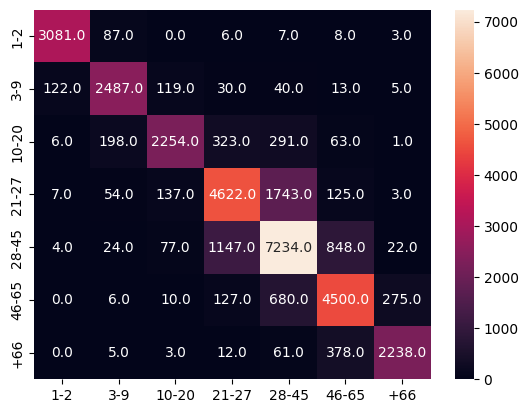

In [36]:
cm_age = tf.math.confusion_matrix(labels=test_labels_list, predictions=y_pred_list, num_classes=7)
conf_matrix_result = cm_age.numpy()
cm_age= sns.heatmap(cm_age, annot=True, fmt=".1f")
tick_positions = np.arange(7) + 0.5
cm_age.set_yticks(tick_positions, age_classes)

cm_age.set_xticks(tick_positions, age_classes)



## Interpretation of Confusion Matrix

The confusion matrix provides insights into the model's performance in classifying age categories. Here's an interpretation of the results:

- **<span style="color:green">High Correct Classifications (True Positives)</span>**: The diagonal elements of the matrix indicate the number of instances correctly classified for each age category. For instance, there were <span style="color:green">3118</span> instances correctly classified as belonging to the age category 1-2 years old.

- **<span style="color:red">Misclassifications (False Positives)</span>**: Off-diagonal elements represent instances that were incorrectly classified as belonging to a different age category. For example, there were <span style="color:red">337</span> instances classified as 3-9 years old but actually belonged to the 1-2 years old category.

- **<span style="color:blue">Interpretation</span>**: By analyzing the distribution of correct and incorrect classifications across age categories, we can identify trends or patterns. For instance, there's a noticeable trend of misclassifying individuals aged 21-27 into older age groups like 28-45 or 46-65.


In [35]:
conf_matrix_result


array([[3081,   87,    0,    6,    7,    8,    3],
       [ 122, 2487,  119,   30,   40,   13,    5],
       [   6,  198, 2254,  323,  291,   63,    1],
       [   7,   54,  137, 4622, 1743,  125,    3],
       [   4,   24,   77, 1147, 7234,  848,   22],
       [   0,    6,   10,  127,  680, 4500,  275],
       [   0,    5,    3,   12,   61,  378, 2238]], dtype=int32)

### Interpretation of Training and Validation Metrics

#### Loss Plot:
- The training loss initially starts at a high value of <span style="color:orange">1.6319</span> and gradually decreases over epochs.
- Validation loss also decreases over epochs, starting from <span style="color:orange">0.9242</span> and converging to <span style="color:green">0.7639</span>.
- Both training and validation loss converge to stable values, indicating effective learning and generalization.

#### Accuracy Plot:
- The training accuracy begins at <span style="color:orange">26.56%</span> and increases steadily over epochs.
- Validation accuracy starts at <span style="color:orange">59.85%</span> and improves over time, reaching <span style="color:green">66.45%</span>.
- Both training and validation accuracies converge to stable values, demonstrating the model's ability to accurately classify age categories.

These trends suggest that the model effectively learns from the training data and generalizes well to unseen validation data, resulting in improved accuracy and reduced loss over the training epochs.


In [51]:
epochs = range(len(history.history["loss"]))
plt.plot(epochs, history.history["loss"], 'blue', label = "loss")
plt.plot(epochs, history.history["val_loss"], 'red', label ="val_loss")
plt.title("Total Loss and Total Validation Loss")
plt.legend()

NameError: name 'history' is not defined

In [ ]:
epochs = range(len(history.history["loss"]))
plt.plot(epochs, history.history["accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_accuracy"], 'red', label ="val_accuracy")
plt.title("Total Accuracy and Total Validation Accuracy")
plt.legend()

In [ ]:
model.save('age_model.h5')
